# Mounting the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Case_Study_Bengisu_Oniz

/content/drive/My Drive/Case_Study_Bengisu_Oniz


# Ideas & Hypothesis 



## Relation with time of the day, week

Is there any particular relation between the skipping behaviour and time of the day,week?
Maybe listeners are more open to try recommended tracks on Saturdays than Monday or vice verse. Maybe, some listener look for a newness on their first week day.


H0: There is no difference in skipping behavior in different times of the days.
or the skipping behaviour is the same for days of the weeks.

## Relation with track_genre_category

Listeners may be more open to listen recommended tracks from specific track_genre_category.

## Relation with algoritm

Sound Clound has a diverse track database. Amateur users can upload their tracks so it may have more sparse data.

## Relation with the newsness of a track

Maybe listeners are into new tracks than old ones.

# Data Preparation

## Libraries and Reading the 

### Libraries

In [3]:
import warnings

from google.cloud import bigquery
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats
import scipy.stats as ss
#import chart_studio.plotly as py
import json
from matplotlib import mlab
import os
from pandas_profiling import ProfileReport
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import mannwhitneyu # is for independent samples. For related / paired samples, consider

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats


from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from itertools import product
from IPython.display import clear_output
%matplotlib inline

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Functions

In [36]:
def know_your_data(data):
    print('Head: {}'.format(data.ndim))
    print('Shape: {}'.format(data.shape))
    print('Length: {}'.format(data.size))
    print('Columns: {}'.format(data.columns))
    print("-----------------------------------")
    print('Types: {}'.format(data.dtypes))
    print("-----------------------------------")
    print("Nullity Check:\n", pd.isnull(data).any())
    print("Percentage of Null Instances: {}".format(df.isnull().sum() * 100 / len(df)))


def show_hist_plot(df,column_name):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=['indianred'], histnorm='percent')
    yaxis=dict(ticksuffix=".00%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix=".00%") )
    fig1.show()

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00  
    
def create_cum_perc_df(df, column_name):  
    df_counted = df.value_counts([column_name]).rename_axis('unique_values').reset_index(name='counts')
    df_counted['count_running_total'] = df_counted['counts'].cumsum()
    df_counted['percent_of_total'] = df_counted['count_running_total']/df_counted['counts'].sum()*100
    return df_counted  


def have_cum_graph(df,column_name,title, x_label):
    
    df_counted = create_cum_perc_df(df, column_name)
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_counted['unique_values'], y=df_counted['percent_of_total'],
                        mode='lines+markers'))
    fig.update_layout(title= title,
                   xaxis_title= x_label,
                   yaxis_title='Percent of the tracks listened')
    fig.show()  
    

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00
    
def get_part_of_day(df):
    b = [0,4,8,12,16,20,24]
    l = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
    df['part_of_day'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)
    
def get_day_month(df): 
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_week'] = df['date'].dt.day_name()
    df['hour']=df['date'].dt.hour
    
    
def convert_strings_to_datetime(df): 
    df['date'] = pd.to_datetime(df['ts'],unit='s')
    df['track_upload_date'] = pd.to_datetime(df['track_upload_date'],unit='s')
    df['listener_signup_date'] = pd.to_datetime(df['listener_signup_date'],unit='s')

def convert_milliseconds_to_mins(df): 
    df['track_duration_minutes'] = df['track_duration'].div(60000).round(2)
    df['listen_duration_minutes'] = df['listen_duration'].div(60000).round(2)
    df['listener_prev_month_listening_time_minutes'] = df['listener_prev_month_listening_time'].div(60000).round(2)

def stacked_bar_chart_combined_columns(df,grouped_column_1,grouped_column_2,group_column):
    freq_df = df.groupby([grouped_column_1,grouped_column_2])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))

def stacked_bar_chart(df,grouped_column,group_column):
    freq_df = df.groupby([grouped_column])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))


  

def create_violin_plot(df,column_1,column_2):
    fig = go.Figure(data=go.Violin(y=df[column_1], box_visible=True, line_color='black',
                                   meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                   x0='all data'))

    fig.update_layout(yaxis_zeroline=False)

    list_column_2=list(df[column_2].unique())

    for i in list_column_2:
        fig.add_trace(go.Violin(x=df[column_2][df[column_2] == i],
                                y=df[column_1][df[column_2] == i],
                                name=i,
                                box_visible=True,
                                meanline_visible=True))

    fig.show()
    



def get_basic_bar_chart(df,column):
  s_counted=df[column].value_counts()
  df_counted=pd.DataFrame({'labels':s_counted.index, 'count':s_counted.values})
  df_counted['percentage'] = (df_counted['count'] / df_counted['count'].sum()) * 100
  df_counted.plot(kind='bar', x='labels', y='percentage')


def CheckingCorrelations(df,colorstyle):

    column_names=df.columns 
    num = len(column_names)
    correlations = df[column_names].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap=colorstyle)  
    fig.colorbar(cax)
    ticks = np.arange(0, num, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    ax.tick_params(labelsize=13)
    plt.show()
    

    

def cramers_v(df,column_1,column_2):
    
    """ calculate Cramers V statistic for categorial-categorial association.    

        𝑉∈[0.1,0.3]: weak association
        𝑉∈[0.4,0.5]: medium association
        𝑉>0.5: strong association
             
    """
    confusion_matrix = pd.crosstab(df[column_1], df[column_2])
    confusion_matrix=confusion_matrix.values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v =np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    if cramers_v <= 0.3:
      strength='weak'
    elif cramers_v <= 0.5:
      strength='medium'
    else:          
      strength='strong'
    print(column_1,' & ',column_2, "==> cramers_v score is:", cramers_v)
    print("strength of association is:", strength)
    
def get_relation(df, column_1, column_2):
    do_chi_square_test(df,column_1,column_2)
    print('---------------------------------------------------------------')
    cramers_v(df,column_1, column_2) 

def check_variance_mean_diff_of_per_listening_time(column,value_1,value_2):
    alpha = 0.05

    list_1= list(df[df[column]==value_1]['per_listening_time'])
    list_2= list(df[df[column]==value_2]['per_listening_time'])

    result_levene=stats.levene(list_1, list_2)
    conclusion_levene = "Failed to reject the null hypothesis.(There is no diff in the variances)"
    if result_levene.pvalue > alpha:
        conclusion_levene = "Null Hypothesis (There is no diff in the variances) is rejected."

    result_mannwhitneyu=mannwhitneyu(list_1, list_2) 
    conclusion_mannwhitneyu = "Failed to reject the null hypothesis.(There is no diff in the means)"
    if result_mannwhitneyu.pvalue > alpha:
        conclusion_mannwhitneyu = "Null Hypothesis (There is no diff in the means) is rejected."

    print('Check if ',value_1,' & ',value_2, ' have equal variances')
    print(result_levene)
    print(conclusion_levene)
    print('----------------------------------------')
    print('Check if there is significant difference between the means of ',value_1,' & ',value_2 )
    print(result_mannwhitneyu)
    print(conclusion_mannwhitneyu)

def create_box_violin_plots(df,column):
    fig = go.Figure()

    fig.add_trace(go.Violin(y=df[column], box_visible=True, line_color='black',
                                       meanline_visible=True, fillcolor='gold', opacity=0.6,name=column)
                 )
    fig.add_trace(go.Box(y=df[column],name = column,
                    marker_color = 'darkgoldenrod'))

    fig.show()


def show_hist_plot(df,column_name, color_discrete_sequence='indianred'):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=[color_discrete_sequence], histnorm='percent')
    yaxis=dict(ticksuffix="%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix="%") )
    fig1.show()


def remove_outlier_z_score_detection_median(column_name, df):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_median = np.median(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_median)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0] #array
    dataframe = df.drop(indexes,axis=0) 
    return dataframe

def remove_outlier_z_score_detection_mean(df,column_name):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_mean = np.mean(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_mean)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0]
    dataframe = df.drop(indexes)
    return dataframe

def create_basic_violin_plot(df,column):

  fig = go.Figure(data=go.Violin(y=df[column], box_visible=True, line_color='black',
                                meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                x0=column))

  fig.update_layout(yaxis_zeroline=False)
  fig.show()

def do_chi_square_test(df,column_1,column_2):


    # create contingency table
    data_crosstab = pd.crosstab(df[column_1],
                                df[column_2],
                                margins=True, margins_name="Total")
    # significance level
    alpha = 0.05

    # Calcualtion of Chisquare test statistics
    chi_square = 0
    rows = df[column_1].unique()
    columns = df[column_2].unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E

    # The p-value approach
    print("The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis (no relation between variables) is rejected."
    #return (p_value,conclusion)
    print(column_1,' & ',column_2, "==> chisquare-score is:", chi_square, " and p value is:", p_value)
    print(conclusion)


def get_table(df, column_1,column_2):  
    freq_df = df.groupby([column_1,column_2])['is_skipped'].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    pct_df=pct_df.reset_index()             
    pct_df.drop(columns=['False',],inplace=True)
    pct_df=round(pct_df.pivot_table('True', column_1,column_2, fill_value=0),2)
    return pct_df

### Reading the data

In [6]:
#path = f'/Users/b.oeniz/Documents/sc_data_science_challenge.json'
#os.chdir('/Users/b.oeniz/Documents')

# Reading the json as a dict
with open('sc_data_science_challenge.json') as json_data:
    data = json.load(json_data)
type(data)


json_obj=json.load(open('sc_data_science_challenge.json'))
df_raw=pd.DataFrame(json_obj['data'],columns=json_obj['columns'])

## Data Manipulation

In [35]:
#all the data manipulations, please run this chunk to have the final data

df=df_raw.copy()

df = df.astype(dtype={'listener_id': 'string','country_code': 'string'})
df.convert_dtypes()

df.drop_duplicates(inplace=True)
df.duplicated().any()
df = df.drop(df[(df['listen_duration'] < 0)].index)
df.dropna(inplace=True)
df = df.replace('None', np.nan).dropna(how='all')

convert_strings_to_datetime(df)
convert_milliseconds_to_mins(df)
get_day_month(df)
get_part_of_day(df)
df["day_of_week+part_of_day"] = df["day_of_week"].astype(str)  + df["part_of_day"].astype(str) 

df["raw_per_listening_time"] = round(df["listen_duration_minutes"]/df["track_duration_minutes"],2)


#dropping the inf numbers
with pd.option_context('mode.use_inf_as_na', True):
    df = df.dropna(subset=['raw_per_listening_time'], how='all')
pd.set_option('use_inf_as_na', True)

    
convert_per_listening_time_to_one(df)

df = df.drop(df[(df['listen_duration'] < 0)].index)

df = df.drop(df[(df['per_listening_time'] < 0.00)].index)

df = remove_outlier_z_score_detection_median('listen_duration_minutes', df)
df = remove_outlier_z_score_detection_median('track_duration_minutes', df)



#list_is_skipped = []
# #use apply function
# for index, row in df.iterrows():
#   if row['track_genre_category'] =='Speech':   
#       if row['listen_duration_minutes'] >5 :
#           list_is_skipped.append('False')
#       elif row['per_listening_time'] > 0.3:
#           list_is_skipped.append('False')
#       else:
#           list_is_skipped.append('True')
#   else:
#       if row['listen_duration_minutes'] > 3 :
#           list_is_skipped.append('False')
#       elif row['per_listening_time'] > 0.3:
#           list_is_skipped.append('False')
#       else:
#           list_is_skipped.append('True')

# df['is_skipped'] = list_is_skipped


def define_skipping(listen_duration_minutes,track_genre_category,per_listening_time):

    if track_genre_category == 'Speech':
        if listen_duration_minutes > 5:
            return 'False'
        elif per_listening_time > 0.3:
            return 'False'
        else:
            return 'True'
    else:
        if listen_duration_minutes > 3:
            return 'False'
        elif per_listening_time > 0.3:
            return 'False'
        else:
            return 'True'

df['is_skipped'] = df.apply(lambda x: define_skipping(x['listen_duration_minutes'],x['track_genre_category'],x['per_listening_time']),axis=1)


perc_type = []

for i in df['per_listening_time']:
    if i <= 0.69:
        perc_type.append('medium')
    elif i <= 0.95:
        perc_type.append('high')
    else:
        perc_type.append('complete')
        
        
df['percentage_type'] = perc_type
        
  
list_is_listener_signup_date = []
list_user_type = []

for index, row in df.iterrows():
    if row['date'] == row['listener_signup_date']:
        list_is_listener_signup_date.append('True')
        list_user_type.append('new user')
    else:
        list_is_listener_signup_date.append('False')
        list_user_type.append('returning user')

        
df['is_listener_signup_date'] = list_is_listener_signup_date
df['user_type'] = list_user_type

list_is_track_old = []

for index, row in df.iterrows():
    if abs((row['date'] - row['track_upload_date']).days) > 365 :
        list_is_track_old.append('True')
    else:
        list_is_track_old.append('False')
       

df['is_track_old'] = list_is_track_old


list_is_same_genre = []

for index, row in df.iterrows():
    if row['track_genre_category'] == row['listener_top_genre_category_listened']:
        list_is_same_genre.append('True')
    else:
        list_is_same_genre.append('False')

df['is_same_genre'] = list_is_same_genre


# Hypothesis Checking

### Is the day of the week can be a factor?

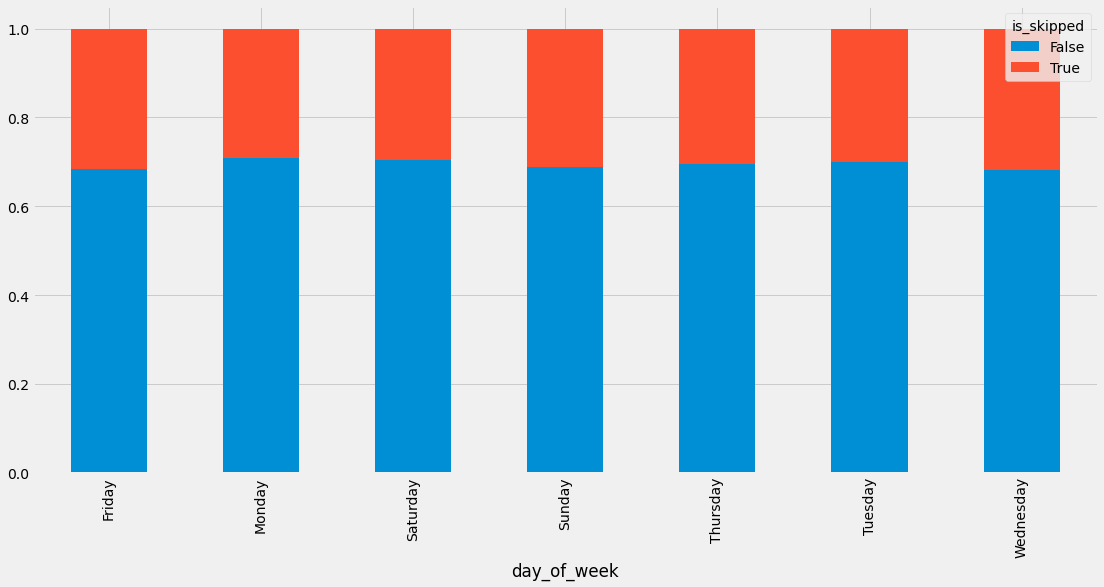

In [37]:
stacked_bar_chart(df,'day_of_week','is_skipped')

In [38]:
get_relation(df, 'day_of_week', 'is_skipped')

The p-value approach to hypothesis testing in the decision rule
day_of_week  &  is_skipped ==> chisquare-score is: 325.808207865605  and p value is: 0.0
Null Hypothesis (no relation between variables) is rejected.
---------------------------------------------------------------
day_of_week  &  is_skipped ==> cramers_v score is: 0.020774786653984762
strength of association is: weak


In [ ]:
create_violin_plot(df,'per_listening_time','day_of_week')


> There is  weak relation between day_of_week and skipping behavior








In [ ]:
stacked_bar_chart(df,'part_of_day','is_skipped')

People may be more open to listen recommended songs in the mornings since they are back to their routines in the mornings, they may look for newness 

In [ ]:
create_violin_plot(df,'per_listening_time','part_of_day')

In [ ]:
get_relation(df, 'part_of_day', 'is_skipped')

> There is a weak relation between part_of_day and skipping behavior

In [ ]:
stacked_bar_chart_combined_columns(df,'day_of_week','part_of_day','is_skipped')

We can see a pattern in this graph. There should be a pattern users to be more open to listen the recommended tracks

In [ ]:
tb = get_table(df,'day_of_week','part_of_day')
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm,axis=None, low=0.1, high=0.6)

In [ ]:
get_relation(df, 'day_of_week+part_of_day', 'is_skipped')



> Even though, there is a weak relation between day_of_week + part_of_day, there is a  higher relation than day_of_week and part_of_day alone. Users skip recommended songs less on Monday and Tuesday mornings



In [ ]:
tb = get_table(df,'day_of_week','part_of_day')
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm,axis=None, low=0.1, high=0.6)

### Is algoritm can be a factor?

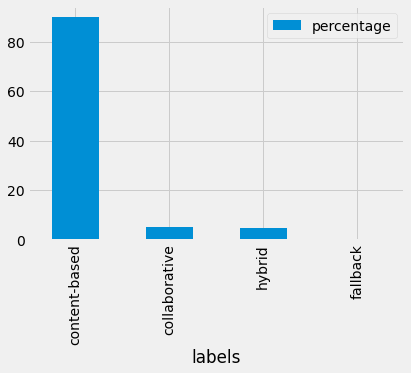

In [8]:
get_basic_bar_chart(df,'recommender_algorithm_name')

There is a big difference in number of tracks from content-based and other algorithms. This may be a problem for comparing the success of the algorithms 🧐

In [9]:
get_relation(df, 'recommender_algorithm_name', 'is_skipped')

The p-value approach to hypothesis testing in the decision rule
recommender_algorithm_name  &  is_skipped ==> chisquare-score is: 1151.2593081583098  and p value is: 0.0
Null Hypothesis (no relation between variables) is rejected.
---------------------------------------------------------------
recommender_algorithm_name  &  is_skipped ==> cramers_v score is: 0.03936513649915948
strength of association is: weak


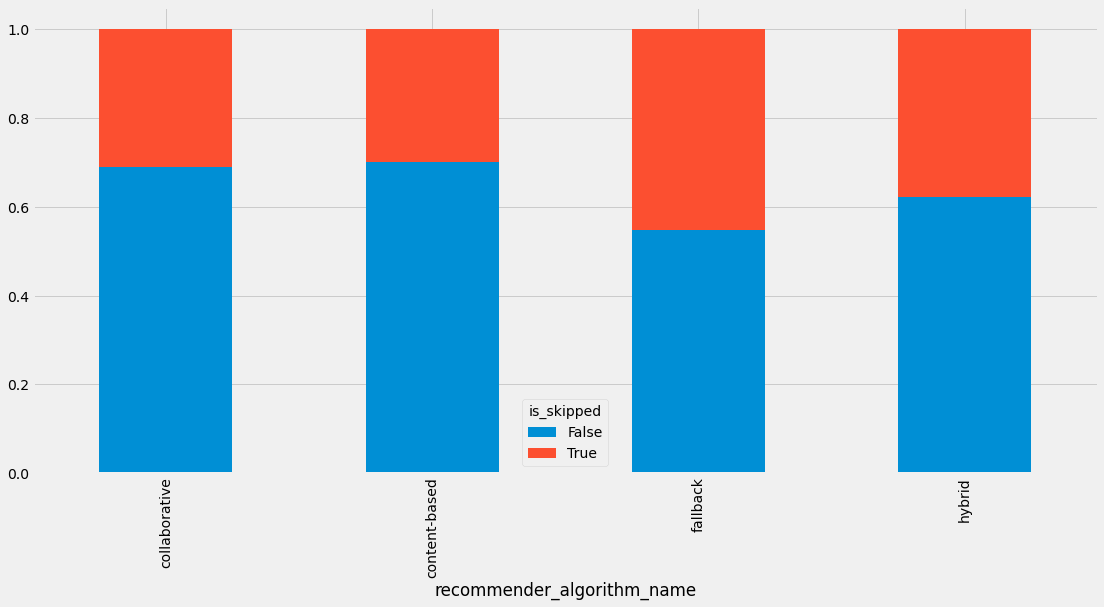

In [10]:
stacked_bar_chart(df,'recommender_algorithm_name','is_skipped')

In [11]:
create_violin_plot(df,'per_listening_time','recommender_algorithm_name')

Output hidden; open in https://colab.research.google.com to view.

In [12]:
df.recommender_algorithm_name.unique()

array(['content-based', 'hybrid', 'fallback', 'collaborative'],
      dtype=object)

In [13]:
# To make sure if there is significant differences between the values as they are seen from the graphs above
check_variance_mean_diff_of_per_listening_time('recommender_algorithm_name','content-based','collaborative')

Check if  content-based  &  collaborative  have equal variances
LeveneResult(statistic=62.26696287385948, pvalue=3.0034102370037603e-15)
Failed to reject the null hypothesis.(There is no diff in the variances)
----------------------------------------
Check if there is significant difference between the means of  content-based  &  collaborative
MannwhitneyuResult(statistic=12536643541.0, pvalue=3.568512663666821e-21)
Failed to reject the null hypothesis.(There is no diff in the means)




> There is a relation with skipped behaviour and recommendation algorithm. Content-based model is the most succesful algorithm for listeners not to skip recommended track. Hybrid is less succesful than content based and collaborative



#### recommender_algorithm_name with user_type

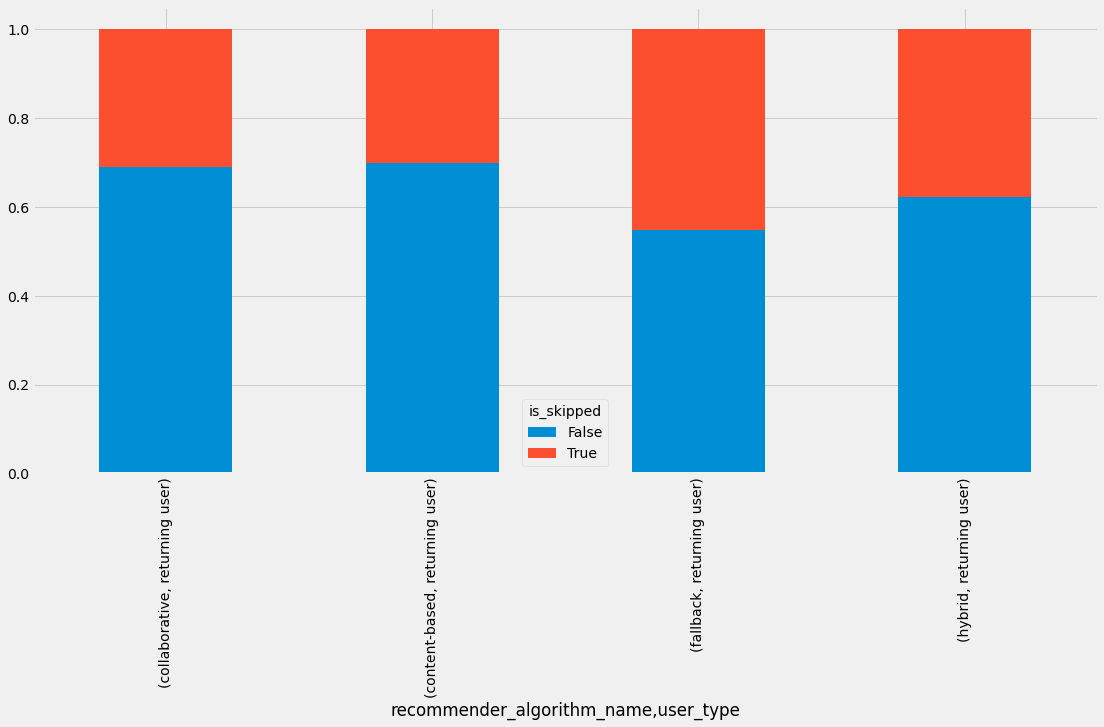

In [14]:
stacked_bar_chart_combined_columns(df,'recommender_algorithm_name','user_type','is_skipped')



> Content-base algorithm works for returning users better than other algorithms



### recommender_algorithm_name with track_genre_category

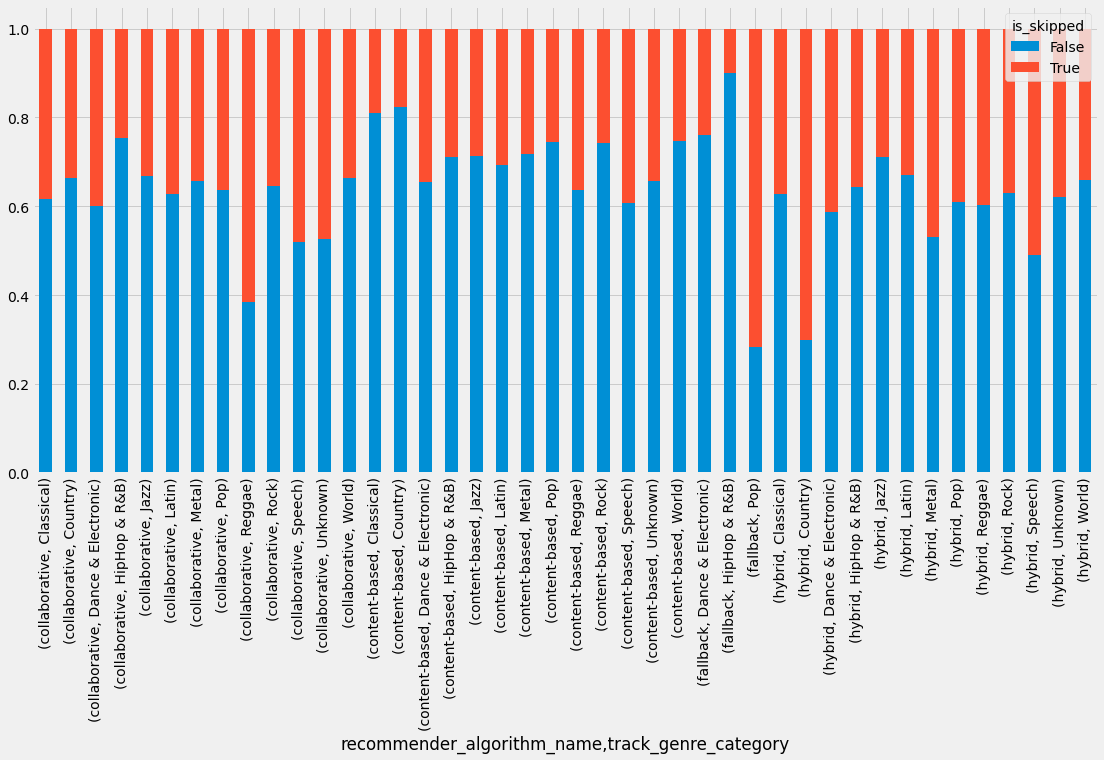

In [15]:
stacked_bar_chart_combined_columns(df,'recommender_algorithm_name','track_genre_category','is_skipped')

In [16]:
# print('Skipping percentages of the combined features')
# tb = get_table(df,'recommender_algorithm_name','track_genre_category')
# cm = sns.light_palette("pink", as_cmap=True)
# tb.style.background_gradient(cmap=cm,axis=None)

Skipping percentages of the combined features


KeyError: ignored

In [17]:
freq_df = df.groupby(['track_genre_category'])['is_track_old'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
round(pct_df,2)

is_track_old,False,True
track_genre_category,,
Classical,0.32,0.68
Country,0.31,0.69
Dance & Electronic,0.58,0.42
HipHop & R&B,0.56,0.44
Jazz,0.49,0.51
Latin,0.54,0.46
Metal,0.46,0.54
Pop,0.38,0.62
Reggae,0.43,0.57


It seems some algorithms for some genres works better for listeners not to skip the tracks

* Algorithm 'content-based' works Genre 'Classic' & 'Country'. This is expected because the percentages of old tracks iares higher for these genres so the algorithms have more information about the usage of the tracks.

* Algorithm 'fallback' works Genre 'HipHop & R&B'. Popular songs of 'HipHop & R&B' serves listeners' taste. Or listeners of this genre are more interested in listening top songs of the genre. Algorithm 'collaborative' works Genre 'HipHop & R&B' too.

* Algorithm 'content-based' works Genre 'World'.


### Is the listening_context of a track can be a factor?

● **listening_context**: the section of the SoundCloud web app where the user listened to the
recommended track

    ○ “collection”: any of the pages in the Collection section
    ○ “you”: the listener’s own profile page
    ○ “search”: any of the pages in the Search experience
    ○ “stream”: the page of the Stream experience
    ○ “personal-recommended’: the page of the Discover experience for personalized
    recommendations
    ○ “charts”: the page of the Charts experience for trending content discovery
    ○ “tracks”: the dedicated page of an uploaded track
    ○ “users”: the profile page of another user (not the one listening)
    ○ “playlists”: the dedicated page of a playlist

Since listening context has higher correlation with is_skipped feature than other features(even though it is only 0.13), listeners may listen more tracks from specific context.

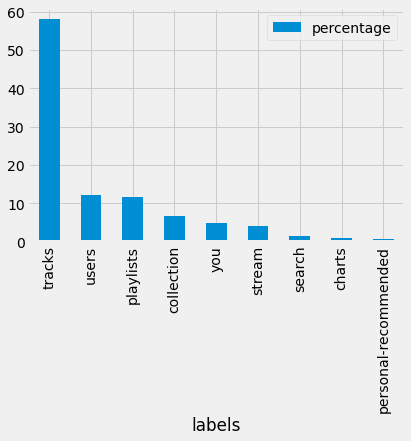

In [18]:
get_basic_bar_chart(df,'listening_context')

Most of the recommended tracks are in tracks's page, *mostly related tracks*

In [19]:
get_relation(df, 'listening_context', 'is_skipped')

The p-value approach to hypothesis testing in the decision rule
listening_context  &  is_skipped ==> chisquare-score is: 56130.52299390372  and p value is: 0.0
Null Hypothesis (no relation between variables) is rejected.
---------------------------------------------------------------
listening_context  &  is_skipped ==> cramers_v score is: 0.27520756539327196
strength of association is: weak


In [20]:
fig = px.box(df, x="listening_context", y="per_listening_time")
fig.show()

Output hidden; open in https://colab.research.google.com to view.



> Interquartile range of content *'you,search and stream'* are higher than other contents. For other contents, the data is disturibed widely. For search whether users listen the most of the tracks or were not interested in the recommended tracks at all.



In [21]:
create_violin_plot(df,'per_listening_time','listening_context')        

Output hidden; open in https://colab.research.google.com to view.

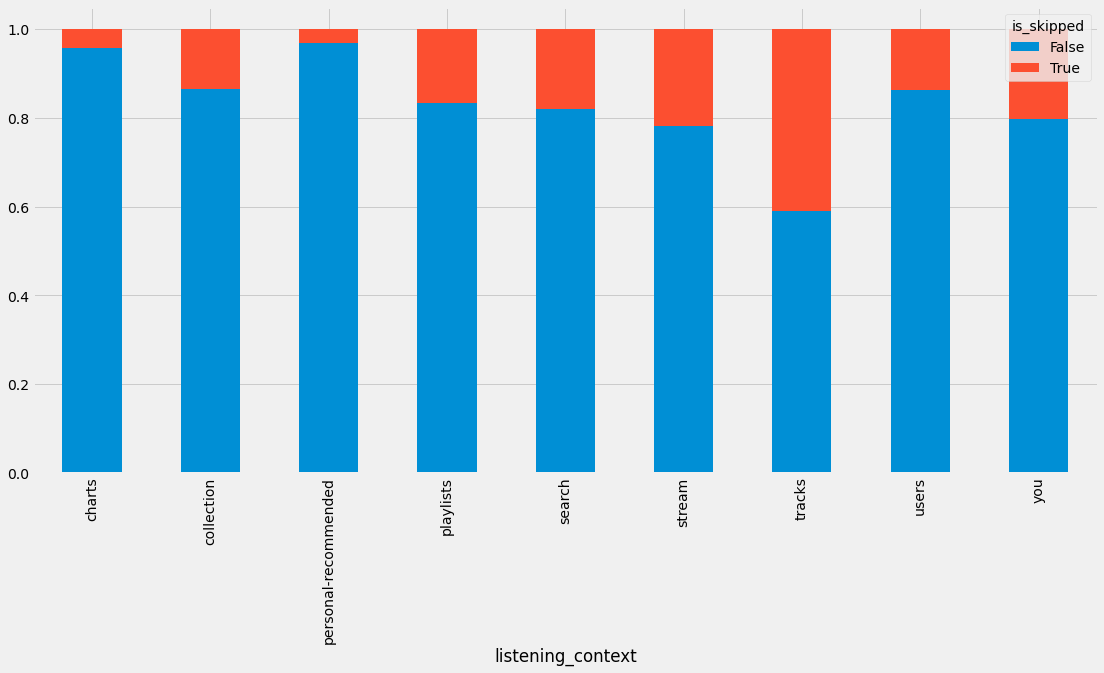

In [22]:
stacked_bar_chart(df,'listening_context','is_skipped')

In [23]:
df.listening_context.unique()

array(['tracks', 'users', 'collection', 'playlists', 'stream', 'you',
       'search', 'personal-recommended', 'charts'], dtype=object)

In [24]:
# To make sure if there is significant differences between the values as they are seen from the graphs above
check_variance_mean_diff_of_per_listening_time('listening_context','tracks','personal-recommended')

Check if  tracks  &  personal-recommended  have equal variances
LeveneResult(statistic=16789.412207274512, pvalue=0.0)
Failed to reject the null hypothesis.(There is no diff in the variances)
----------------------------------------
Check if there is significant difference between the means of  tracks  &  personal-recommended
MannwhitneyuResult(statistic=545310420.5, pvalue=0.0)
Failed to reject the null hypothesis.(There is no diff in the means)


In [25]:
check_variance_mean_diff_of_per_listening_time('listening_context','search','stream')

Check if  search  &  stream  have equal variances
LeveneResult(statistic=84.81377788247482, pvalue=3.4373668772153233e-20)
Failed to reject the null hypothesis.(There is no diff in the variances)
----------------------------------------
Check if there is significant difference between the means of  search  &  stream
MannwhitneyuResult(statistic=133334639.0, pvalue=1.4463244348280534e-27)
Failed to reject the null hypothesis.(There is no diff in the means)




> There is significant difference in means of percentage of listening time of  'tracks' and 'personal-recommended' listening context .


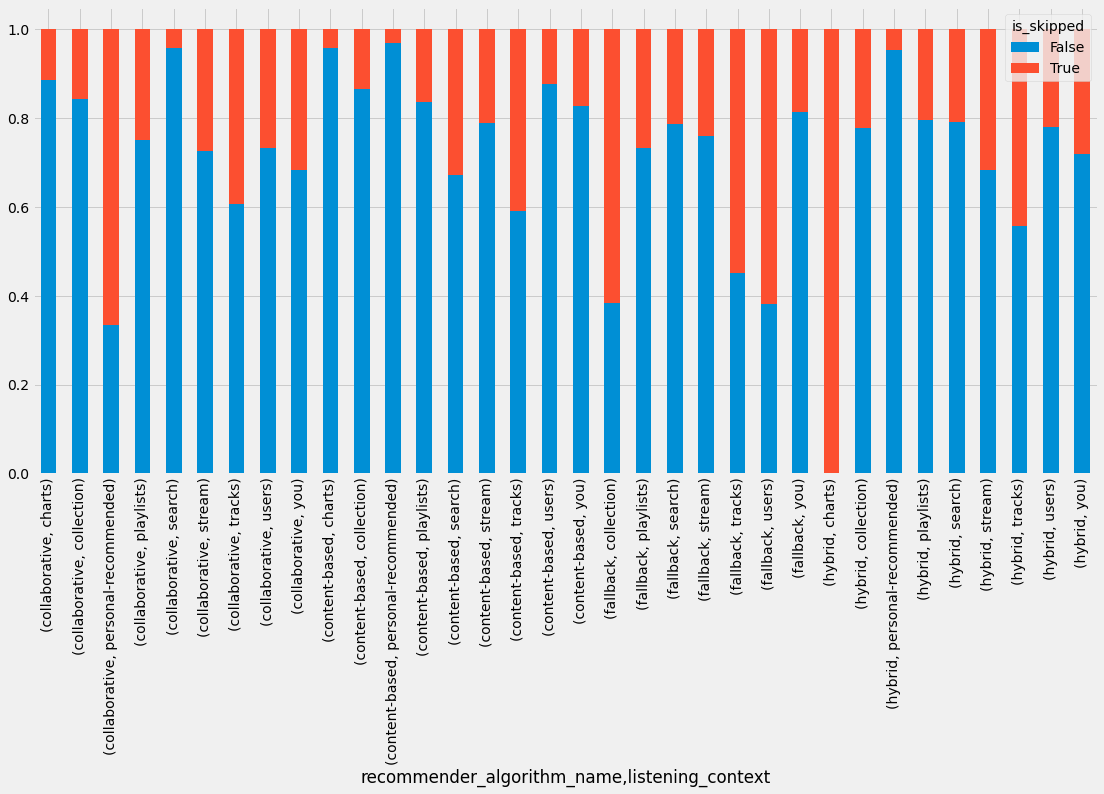

In [26]:
stacked_bar_chart_combined_columns(df,'recommender_algorithm_name','listening_context','is_skipped')



> Listeners only listen less than 55 % of the tracks produced by fallback and hybrid algorith at the charts page.



In [ ]:
print('Skipping percentages of the combined features')

tb = get_table(df,'recommender_algorithm_name','listening_context')
cm = sns.light_palette("pink", as_cmap=True)
tb.style.background_gradient(cmap=cm,axis=None)




> Collaborative algorithm doesn't work well for personal recommeded page whereas it works well for search.  



In [ ]:
print('Skipping percentages of the combined features')

tb = get_table(df,'track_genre_category','listening_context')
cm = sns.light_palette("pink", as_cmap=True)
tb.style.background_gradient(cmap=cm,axis=None)

### Is track_genre_category can be a factor?


In [ ]:
get_basic_bar_chart(df,'track_genre_category')

In [ ]:
get_relation(df, 'track_genre_category', 'is_skipped')

In [ ]:
create_violin_plot(df,'per_listening_time','track_genre_category')

In [ ]:
colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 12, colortype='rgb')

fig = go.Figure()
for data_line, color in zip(df, colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()


In [ ]:
stacked_bar_chart(df,'track_genre_category','is_skipped')

In [ ]:
df.track_genre_category.unique()


In [ ]:
# To make sure if there is significant differences between the values as they are seen from the graphs above
check_variance_mean_diff_of_per_listening_time('track_genre_category','Pop','Rock')



> There is a difference in the means of pop and rock genres



### Is listener_top_genre_category_listened can be a factor?


In [ ]:
get_basic_bar_chart(df,'listener_top_genre_category_listened')

In [ ]:
get_basic_bar_chart(df,'is_same_genre')

In [ ]:
create_violin_plot(df,'per_listening_time','is_same_genre')

In [ ]:
get_relation(df, 'is_same_genre', 'is_skipped')



> There is too weak relation between the genre recommended and the top gengre listened for the user.



In [ ]:
create_violin_plot(df,'per_listening_time','listener_top_genre_category_listened')

In [ ]:
stacked_bar_chart(df,'listener_top_genre_category_listened','is_skipped')

Listeners of Country & Speech listen the recommeded tracks less than other genres of the listeners

In [ ]:
stacked_bar_chart_combined_columns(df,'recommender_algorithm_name','listener_top_genre_category_listened','is_skipped')

In [ ]:
freq_df = df.groupby(['recommender_algorithm_name','listening_context'])['is_skipped'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df.to_excel("pct_df_recommender_algorithm_name_listening_context.xlsx")  
pct_df

In [ ]:
freq_df = df.groupby(['track_genre_category','is_track_old'])['is_skipped'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df.to_excel("track_genre_category_is_track_old.xlsx")  


The behaviour of listening the recommended genre may be related with users' top genre preferences.

* Listeners of Country and Reggae don't listen any recommended tracks from fallback.
* Listeners of Classical and Metal  listen  recommended tracks from fallback less. 
The listener of these genres may not be interested in popular tracks. However, listeners of Latin genre are interested in.

This graphic shows some recommended tracks work for the specific genre of listeners. Of course, this is related with the nature of the genres and profiles of the users.

### Is newsness of a track can be a factor?

In [ ]:
get_basic_bar_chart(df,'is_track_old')


In [ ]:
stacked_bar_chart(df,'is_track_old','is_skipped')

In [ ]:
list_perc_old_tracks= list(df[df['is_track_old']=="True"]['per_listening_time'])
list_perc_new_tracks= list(df[df['is_track_old']=="False"]['per_listening_time'])

print('t-test = %6.3f pvalue = %6.4f' % ztest(list_perc_old_tracks, list_perc_new_tracks, value=0) )

Since this p-value is less than .05, we have sufficient evidence to reject the null hypothesis. In other words, the means of percentage of tracks listened are significantly different between old and new tracks.

In [ ]:
create_violin_plot(df,'per_listening_time','is_track_old')        

In [ ]:
# To make sure if there is significant differences between the values as they are seen from the graphs above
check_variance_mean_diff_of_per_listening_time('is_track_old','False','True')


> When old tracks are recommended, they are more likely to listen more. This is expected since the recommendation algorithms have more information about tracks' listened behavior. There must be a sense of familiarity of course.


In [ ]:
stacked_bar_chart_combined_columns(df,'recommender_algorithm_name','is_track_old','is_skipped')

It seems fallback algorithm doesn't work well.

In [ ]:
print('Skipping percentages of the combined features')
tb = get_table(df,'recommender_algorithm_name','is_track_old')
cm = sns.light_palette("pink", as_cmap=True)
tb.style.background_gradient(cmap=cm,axis=None)

In [ ]:
freq_df = df.groupby(['recommender_algorithm_name','is_track_old'])['is_skipped'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df.to_excel("pct_df_recommender_algorithm_name_is_track_old.xlsx")  

### Is user_type can be a factor?

In [ ]:
get_basic_bar_chart(df,'user_type')

There is no new user in the data set